# Homework 1 Tinkoff Education DL course
## First task: 
Train simple nn (no convolutions) with 97.5+ % on mnist validation

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib as mpl

from torchvision import datasets
from torchvision import transforms as tfs

mpl.style.use('ggplot')

In [3]:
def get_loader(is_train: bool, batch_size: int):
    data_tfs = tfs.Compose([
        tfs.ToTensor(),
        tfs.Normalize((0.5),(0.5))
    ])
    dataset = datasets.MNIST("mnist", train=is_train, download=True, transform=data_tfs)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader
train = get_loader(True, 1024)
val = get_loader(False, 1024)

C:\Users\TOPAPEC\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
import numpy as np

In [20]:
# Functions for training: 
def accuracy(model, val):
    model.eval()
    total = 0
    correct = 0
    for X, y in val:
        X = X.cuda()
        y = y.cuda()
        X = X.view(-1, 784)
        res = model(X)
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y).sum().item()
    return correct / total

def train_model(model, optimizer_alg, criterion, train, val, epochs, lr):
    model = model.cuda()
    model.train()
    optimizer = optimizer_alg(model.parameters(), lr=lr)
    train_losses = []
    acc_test_val = np.zeros((2,epochs))
    for epoch in range(epochs):
        for X, y in train:
            X = X.view(-1, 784)
            X = X.cuda()
            y = y.cuda()
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            train_losses.append(loss.item())
            optimizer.step()
        acc_test_val[0][epoch] = accuracy(model, train)
        acc_test_val[1][epoch] = accuracy(model, val)
        print(epoch, acc_test_val[0][epoch], acc_test_val[1][epoch])
    plt.figure(figsize=(15,10))
    plt.plot(train_losses)
    plt.show()
    plt.figure(figsize=(15,10))
    plt.plot(acc_test_val[0])
    plt.plot(acc_test_val[1])
    plt.legend(('train accuracy', 'test accuracy'))
    plt.show()

In [21]:
# Model.
model = nn.Sequential(
    nn.Linear(784, 400),
    nn.ReLU(),
    nn.Linear(400, 300),
    nn.Dropout(p=0.3),
    nn.ReLU(),
    nn.Linear(300, 200),
    nn.ReLU(),
    nn.Linear(200, 100),
    nn.Dropout(p=0.3),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
)
optimizer = torch.optim.Adam
criterion = nn.NLLLoss()

0 0.88735 0.8882
1 0.92695 0.926
2 0.94755 0.9457
3 0.9610666666666666 0.9565
4 0.97075 0.9656
5 0.9721166666666666 0.9666
6 0.9748166666666667 0.9663
7 0.9788666666666667 0.9681
8 0.9822666666666666 0.971
9 0.9849666666666667 0.9748
10 0.9857666666666667 0.9734
11 0.9887666666666667 0.9758
12 0.9869 0.9733
13 0.9916666666666667 0.976
14 0.99395 0.9774
15 0.9938333333333333 0.9787
16 0.9940166666666667 0.9795
17 0.9935166666666667 0.9775
18 0.9942666666666666 0.9786
19 0.9965333333333334 0.9803
20 0.9967666666666667 0.9783
21 0.9947666666666667 0.9803
22 0.9926333333333334 0.9774
23 0.9953166666666666 0.9797
24 0.996 0.9779
25 0.99575 0.9785
26 0.9949166666666667 0.9782
27 0.9956 0.9797
28 0.9953 0.9775
29 0.9986166666666667 0.9826


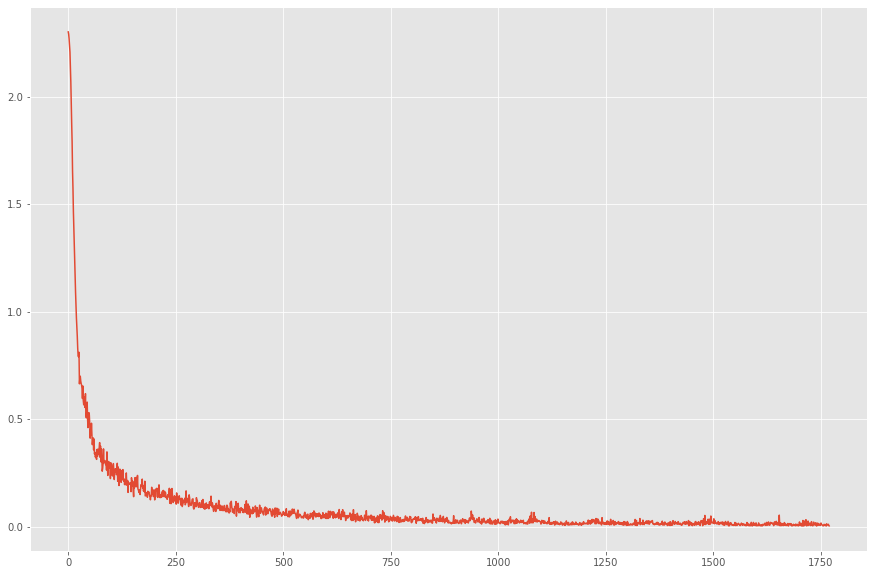

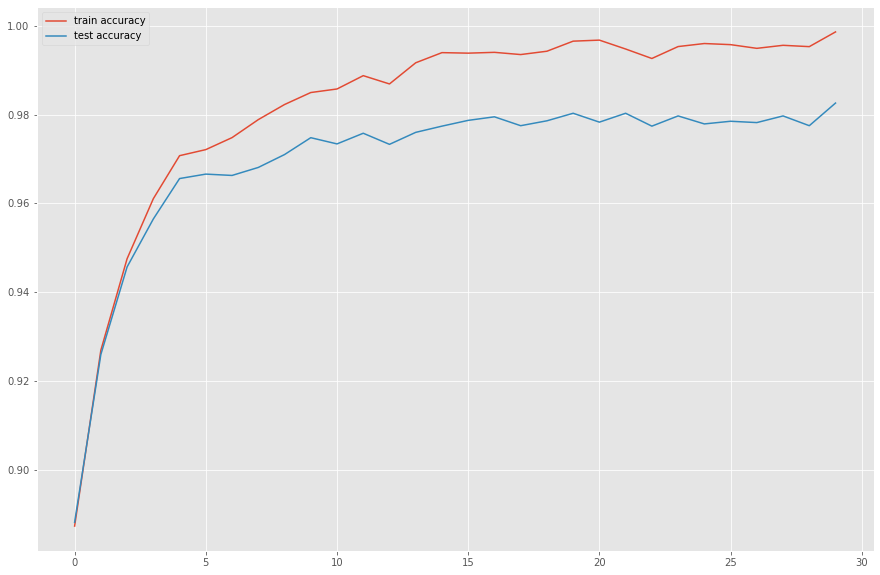

In [22]:
# Training:
train_model(model, optimizer, criterion, train, val, 30, 1e-3)

## Second task:
Build autoencoder, visualise digit morph, visualise mnist dataset on 2d plane

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib as mpl

from torchvision import datasets
from torchvision import transforms as tfs

mpl.style.use('ggplot')

In [4]:
def get_loader(is_train: bool, batch_size: int):
    data_tfs = tfs.Compose([
        tfs.ToTensor()
    ])
    dataset = datasets.MNIST("mnist", train=is_train, download=True, transform=data_tfs)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader
train = get_loader(True, 256)

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.encode = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.ReLU(),
            nn.Linear(200, 50),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(50, 200),
            nn.ReLU(),
            nn.Linear(200, 300),
            nn.ReLU(),
            nn.Linear(300, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.decode(self.encode(x))

In [6]:
def train_autoencoder(model, optimizer_alg, criterion, train, epochs):
    model = model.cuda()
    optimizer = optimizer_alg(model.parameters())
    for epoch in range(epochs):
        train_loss = 0
        for X, _ in train:
            X = X.view(-1, 784)
            X = X.cuda()
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(X, output)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(epoch, train_loss / len(train))

In [12]:
model = Autoencoder()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam

In [13]:
train_autoencoder(model, optimizer, criterion, train, 30)

0 0.0669929694463598
1 0.03758701634533862
2 0.02780615916436023
3 0.023651551661339212
4 0.02049404914550325
5 0.018524507647182078
6 0.016944138139010745
7 0.015798386321105855
8 0.014608253812060712
9 0.013686726844691216
10 0.012954534051266122
11 0.012301518593696837
12 0.011643644259806643
13 0.011058249574233877
14 0.010409357462157594
15 0.009867758097800803
16 0.009459342656934515
17 0.009087589129488519
18 0.008768220424176531
19 0.0085430207642469
20 0.008266231469175917
21 0.008044447569533231
22 0.007856515368961908
23 0.007668583889670195
24 0.007444512521095098
25 0.007287917022613135
26 0.007116052357757345
27 0.006976774509282822
28 0.0068635103451286225
29 0.006703373399424426


In [14]:
import numpy
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

In [15]:
# Functions for creating digit morph.
def get(x):
    return train.dataset[x][0].view(1, 784)

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay):
    device = torch.device("cpu")
    model.to(device)
    latent = [model.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in numpy.linspace(0, 1, steps):
            c = a*(1-t)+b*t
            morphed = model.decode(c).data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

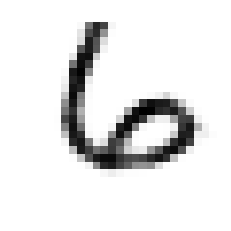

In [16]:
# Generating image morph.
morph(numpy.random.randint(0, len(train.dataset), 30), 20, 30)

In [17]:
%%HTML
<video width="320" height="240" controls>
  <source src="https://thumbs.gfycat.com/ShockedBlaringFoal-mobile.mp4" type="video/mp4">
</video>

In [75]:
# Model for visualising mnist.
class AutoencoderVis(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.encode = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
            nn.Linear(400, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )
        
        self.decode = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.decode(self.encode(x))

In [76]:
model = AutoencoderVis()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam

In [77]:
train_autoencoder(model, optimizer, criterion, train, 20)

0 0.07282422934757903
1 0.05319368255899307
2 0.04810469727566902
3 0.04504344655161208
4 0.043412415825940194
5 0.04232533115972864
6 0.041446296363434894
7 0.040796473400389895
8 0.0403085136667211
9 0.03982701585330862
10 0.03954994038064429
11 0.039189591512401055
12 0.03890144046633801
13 0.038653864663966156
14 0.03845075189750245
15 0.03826863307585107
16 0.038078220030094714
17 0.03785627105451645
18 0.037778868225026636
19 0.037557077677326


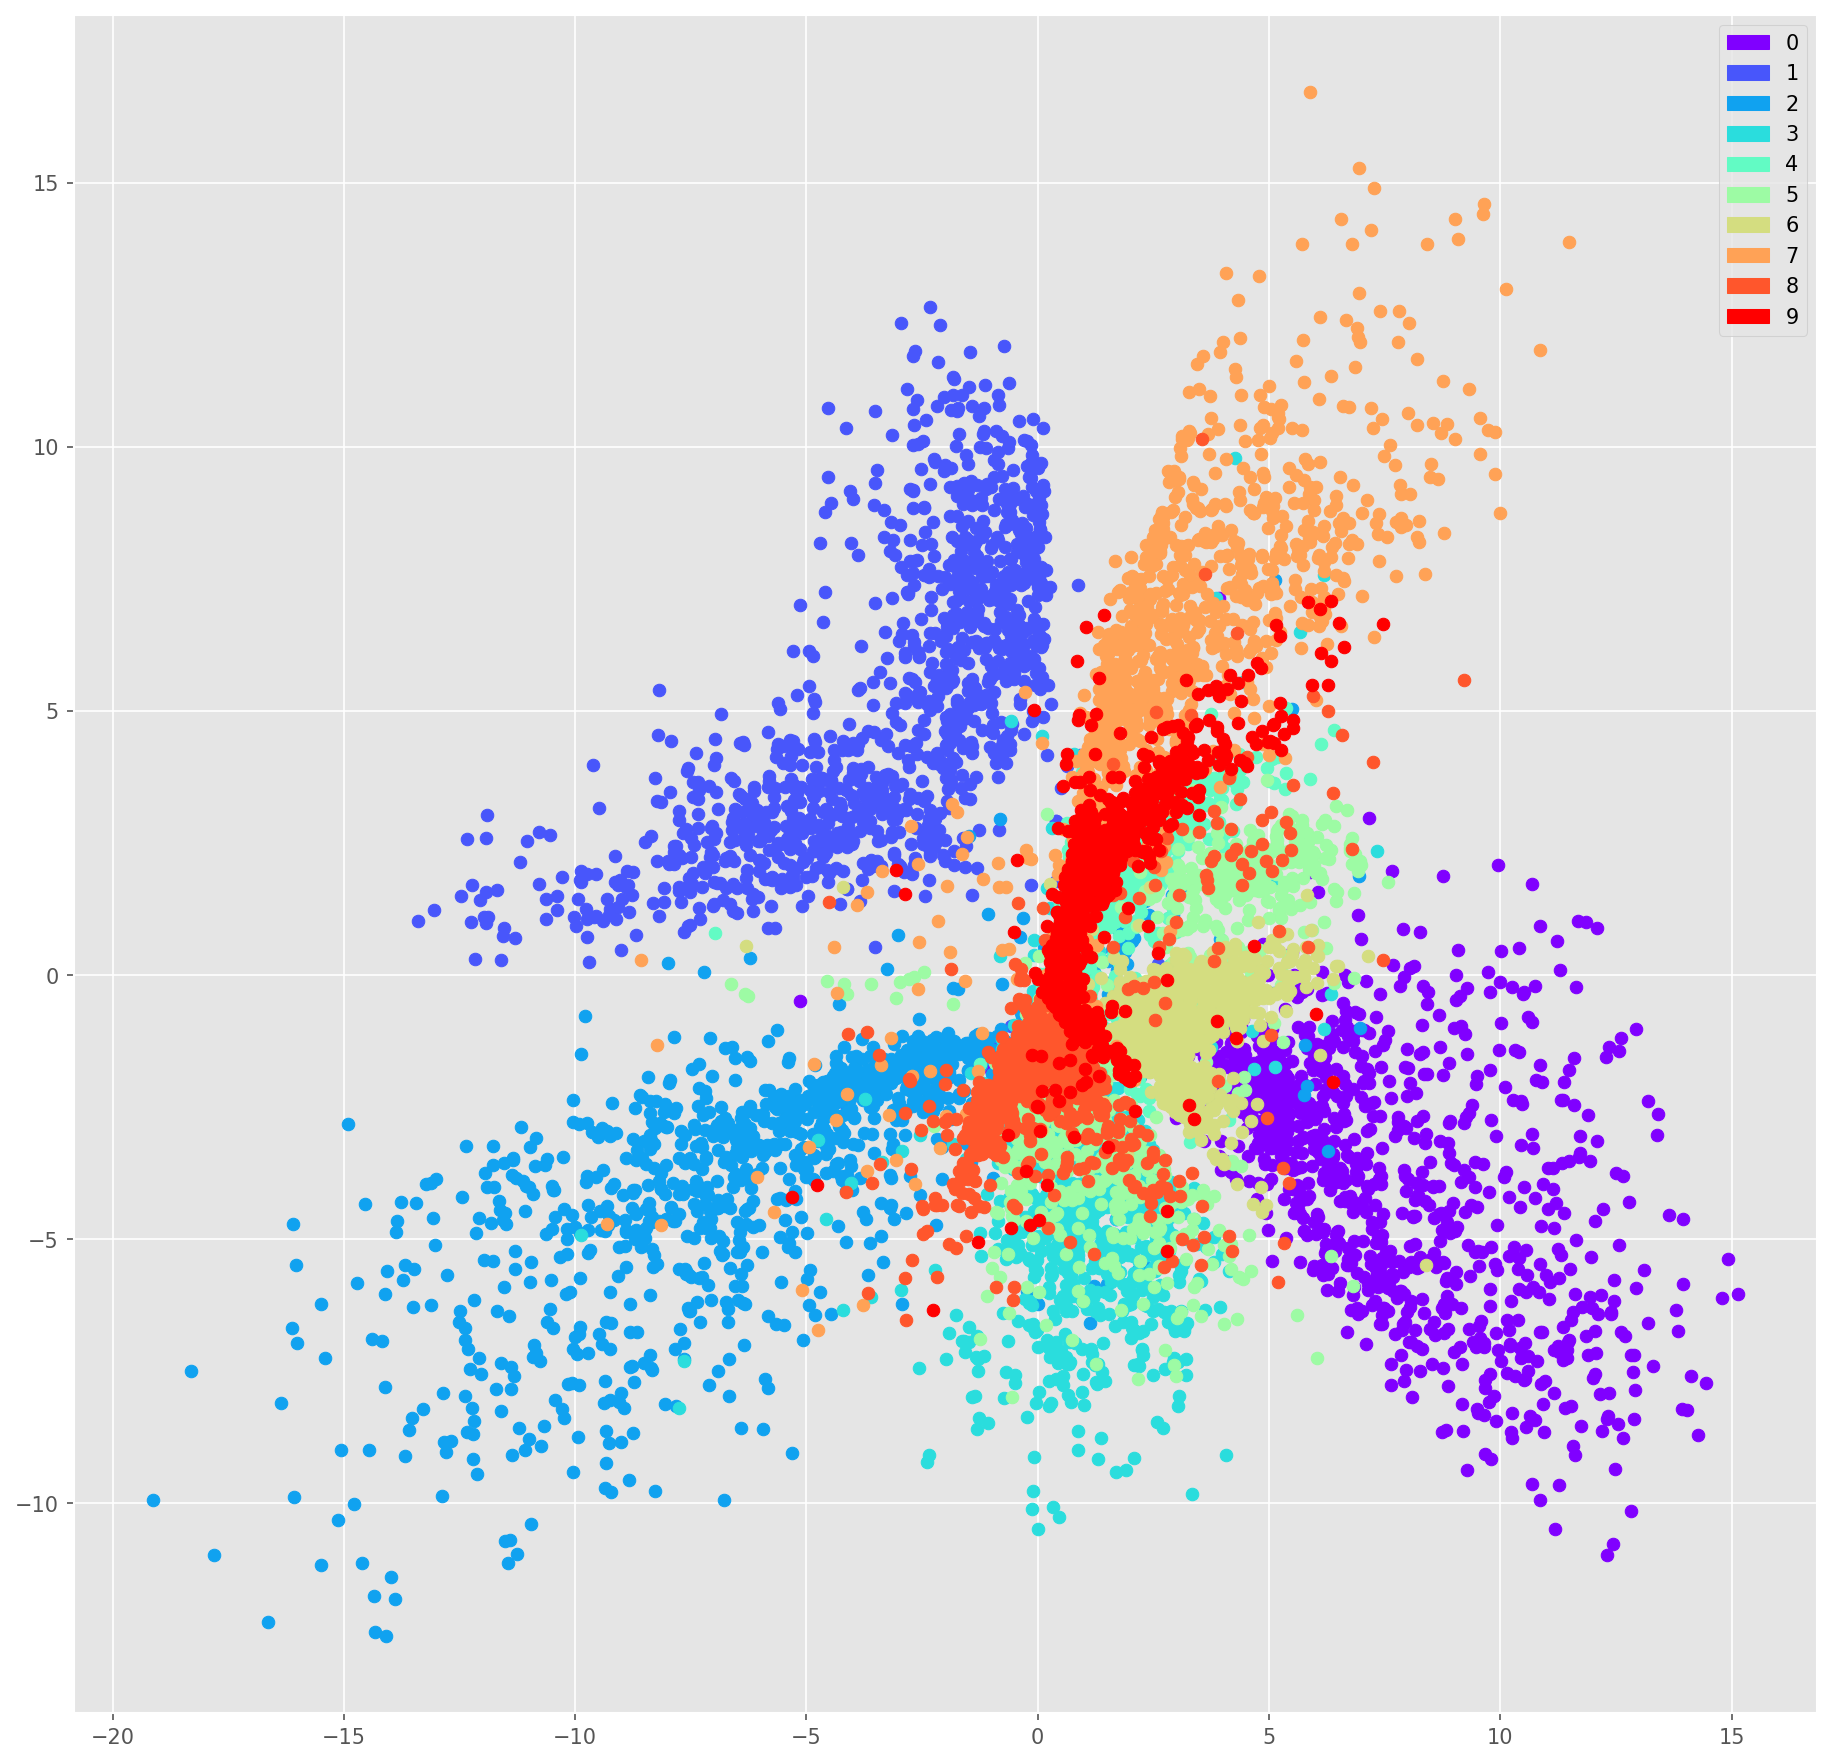

In [78]:
# Generating digits representation.
import matplotlib.patches as mpatches
import matplotlib.cm as cm
dataset = datasets.MNIST("mnist", train=False, download=True, transform=tfs.ToTensor())
digits = [[[] for i in range(2)] for i in range(10)]
device = torch.device("cpu")
model.to(device)
for X, y in dataset:
    array = model.encode(X.view(-1,784)).detach().numpy()
    digits[y][0].append(array[0][0])
    digits[y][1].append(array[0][1])
patches = []
plt.figure(figsize=(15, 15), dpi=150)
colormap = cm.rainbow(numpy.linspace(0, 1, len(digits)))
for y, c in zip(numpy.arange(0, 11, 1), colormap):
    patches.append(mpatches.Patch(color=c, label=y))
    plt.scatter(digits[y][0], digits[y][1], color=c)
plt.legend(handles=patches)

## Third task:
Intro to convolutions - try to classify mnist with convolutions.

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from torchvision import datasets
from torchvision import transforms as tfs

mpl.style.use('ggplot')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
def get_loader(is_train: bool, batch_size: int):
    data_tfs = tfs.Compose([
        tfs.ToTensor(),
        tfs.Normalize((0.5),(0.5))
    ])
    dataset = datasets.MNIST("mnist", train=is_train, download=True, transform=data_tfs)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    return loader
train = get_loader(True, 2048)
val = get_loader(False, 2048)

In [24]:
# Class for out nn with convolutions.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 5)
        self.fc1 = nn.Linear(4 * 4 * 32, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.lsfm = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.dropout(x, p=0.5)
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 4 * 4 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.5)
        x = self.fc3(x)
        x = self.lsfm(x)
        return x

In [25]:
# Functions for training: 
def accuracy(model, val):
    model.eval()
    total = 0
    correct = 0
    for X, y in val:
        X = X.cuda()
        y = y.cuda()
        res = model(X)
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y).sum().item()
    return correct / total

def train_model(model, optimizer_alg, criterion, train, val, epochs, lr):
    model = model.cuda()
    model.train()
    optimizer = optimizer_alg(model.parameters(), lr=lr)
    train_losses = []
    acc_test_val = np.zeros((2,epochs))
    for epoch in range(epochs):
        for X, y in train:
            X = X.cuda()
            y = y.cuda()
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            train_losses.append(loss.item())
            optimizer.step()
        acc_test_val[0][epoch] = accuracy(model, train)
        acc_test_val[1][epoch] = accuracy(model, val)
        print(epoch, acc_test_val[0][epoch], acc_test_val[1][epoch])
    plt.figure(figsize=(15,10))
    plt.plot(train_losses)
    plt.show()
    plt.figure(figsize=(15,10))
    plt.plot(acc_test_val[0])
    plt.plot(acc_test_val[1])
    plt.legend(('train accuracy', 'test accuracy'))
    plt.show()

In [26]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = torch.optim.Adam


0 0.7068 0.7159
1 0.8628833333333333 0.8714
2 0.9124166666666667 0.9166
3 0.9329333333333333 0.9384
4 0.9448166666666666 0.9469
5 0.9522166666666667 0.9556
6 0.9572 0.9622
7 0.9629166666666666 0.9631
8 0.9657166666666667 0.9683
9 0.9692166666666666 0.969
10 0.97105 0.9711
11 0.9716333333333333 0.9741
12 0.9731166666666666 0.9753
13 0.9754666666666667 0.9775
14 0.97785 0.9764
15 0.97845 0.9766
16 0.9775833333333334 0.9788
17 0.9808 0.9806
18 0.9815333333333334 0.9795
19 0.9823333333333333 0.982
20 0.9823 0.9837
21 0.9817833333333333 0.9812
22 0.9842 0.9843
23 0.9839 0.9836
24 0.9840333333333333 0.9818
25 0.9852 0.9841
26 0.9864666666666667 0.9845
27 0.9871833333333333 0.9849
28 0.9852 0.9823
29 0.98635 0.9839
30 0.9869666666666667 0.9834
31 0.9877833333333333 0.9858
32 0.9878 0.9837
33 0.9890833333333333 0.9864
34 0.9878833333333333 0.9856
35 0.9891333333333333 0.9859
36 0.9885333333333334 0.9856
37 0.98885 0.987
38 0.9898333333333333 0.9876
39 0.9896166666666667 0.9869
40 0.99001666666

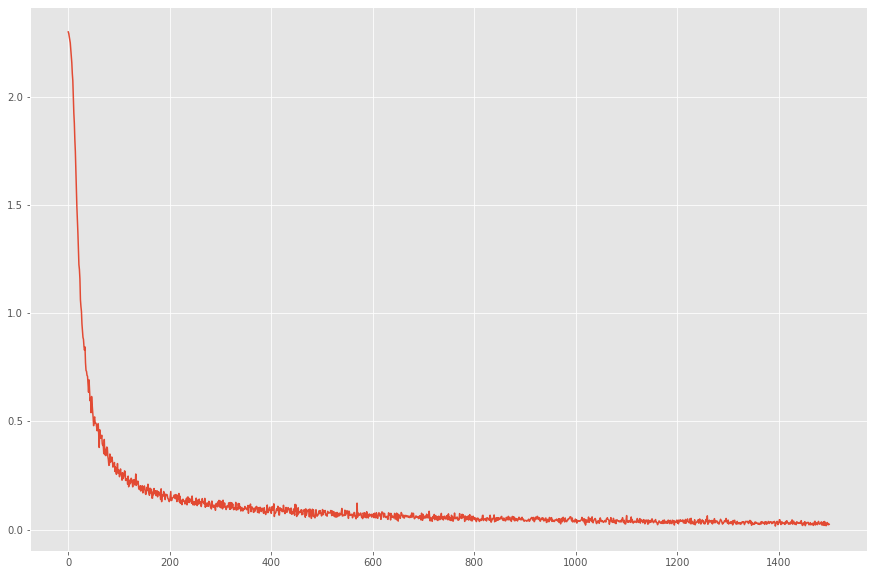

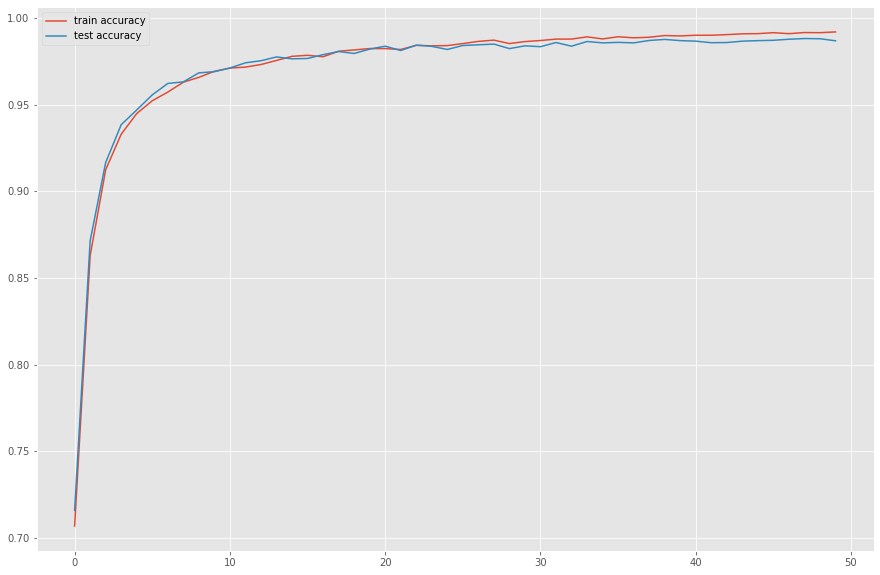

In [27]:
# Training:
train_model(model, optimizer, criterion, train, val, 50, 1e-3)